In [1]:
import os, time
from copy import deepcopy
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.decomposition import PCA

# Pytorch
import torch
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))
from torch.optim import Adam, SGD

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from style import colors
from fig_specs import *
from helpers import color_iterator

from helpers import copy_sd, res_to_cpu, gen_corr
from rnn_model_dt import RNN_Net, find_fp
from task_generators import cycling, flipflop, mante, romo, complex_sine
task_gens = [cycling, flipflop, mante, romo, complex_sine]
task_names = [
    "cycling",
    "flipflop",
    "mante", 
    "romo", 
    "complex_sine", 
]

/tmp/ipykernel_31047/3201032003.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


Use cpu.


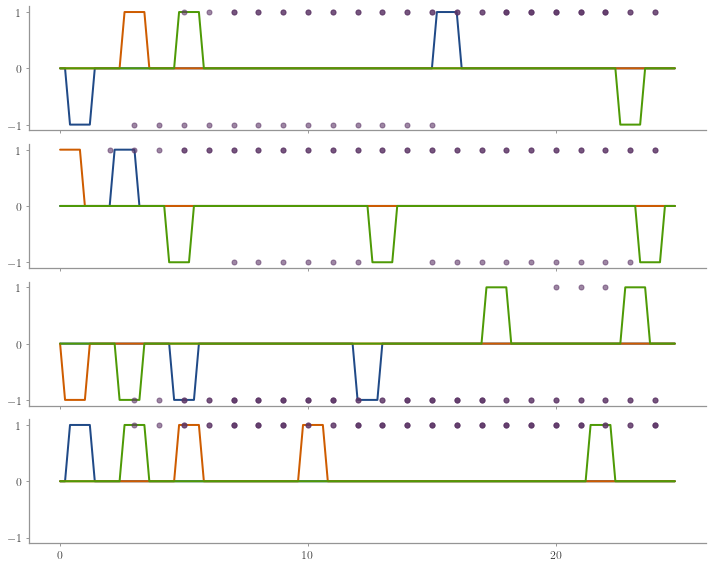

100%|███████████████████████████████████████| 4000/4000 [22:14<00:00,  3.00it/s]


Took 26499.0 sec.
Took 100.68 sec.
Took 13.85 sec.
Took 13.34 sec.
Saved to  ../../data/oblique/neuro_flipflop_n_512.pkl


In [2]:
task_names_train = [
    "cycling",
    "flipflop",
    "mante", 
    "romo", 
    "complex_sine", 
]
for task_name in task_names_train:
    i_task = np.where(task_name == np.array(task_names))[0][0]
    task_generator = task_gens[i_task]

    # Parameters
    n_samples = 5

    # Network
    dim_hid = 512
    n_layers = 2
    bias = False
    train_in = True
    train_hid = True
    train_out = True
    train_layers = [train_in, train_hid, train_out]
    nonlin = torch.nn.Tanh()
    gaussian_init = True
    h_0_std = 0.
    dt = 0.2
    rec_step_dt = 1
    mask_step_dt = 5
    batch_size = 32
    task_params = dict(
        rec_step_dt=rec_step_dt,
    )
    # Noise on input, h_0, and hidden states
    noise_input_std = 0.0
    noise_init_std = 1.0
    noise_hid_std = 0.2

    # Joint scenarios
    out_scales = ['large', 'large', 'small', 'small']
    gs = [0.7, 1.5, 0.7, 1.5]
    n_sce = len(out_scales)
    opt_gens = [Adam]*n_sce
    n_mi = n_samples, n_sce

    if task_name == "cycling":
        n_steps = 1000
        lr0s = [0.02, 0.02, 0.02, 0.02]
        dim_in = 2
        dim_out = 2
    elif task_name == "flipflop":
        n_steps = 4000
        lr0s = [0.01, 0.01, 0.005, 0.005]
        n_fp = 3
        dim_in = n_fp
        dim_out = n_fp
        task_params["n_tasks"] = n_fp
    elif task_name == "mante":
        n_steps = 4000
        lr0s = [0.002, 0.02, 0.002, 0.002]
        n_tasks = 2
        dim_in = 2 * n_tasks
        dim_out = 1
        task_params["n_tasks"] = n_tasks
        noise_hid_std = 0.05
    elif task_name == "romo":
        n_steps = 6000
        lr0s = [0.01, 0.01, 0.01, 0.005]
        dim_in = 1
        dim_out = 1
    elif task_name == "complex_sine":
        n_steps = 6000
        lr0s = [0.01, 0.005, 0.005, 0.005]
        dim_in = 1
        dim_out = 1
        mask_step_dt = 2
    task_params["mask_step_dt"] = mask_step_dt

    # Task generators and fixed eval task
    task_gen = task_generator(dim_in, dim_out, dt, **task_params)
    task_params_ev = deepcopy(task_params)
    task_gen_ev = task_generator(dim_in, dim_out, dt, **task_params_ev)
    ts_ev, input_ev, target_ev, mask_ev = task_gen_ev(batch_size)
    noise_input_ev = noise_input_std * np.float32(np.random.randn(*input_ev.shape)) / np.sqrt(dt)
    noise_init_ev = noise_init_std * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
    n_t_ev = len(ts_ev)
    task_ev = ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev

    # Plot the task
    n_show = min(4, batch_size)
    n_cols = 1
    n_rows = n_show
    fig = plt.figure(figsize=(10, 2 * n_rows))
    axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)
    for i_b in range(n_show):
        ax = axes[i_b, 0]
        # Input
        for i_in in range(dim_in):
            ax.plot(ts_ev, (input_ev + noise_input_ev)[i_b, :, i_in], "-", c=colors[i_in])
        # Target
        for i_out in range(dim_out):
            c = colors[4]
            m = mask_ev[i_b, :, i_out]
            ax.plot(ts_ev[m], target_ev[i_b, :, i_out][m], 'o', ms=5, c=c, alpha=0.6)
    fig.tight_layout()
    style.fixticks(fig)
    plt.show()

    ##############################################################################
    # Train networks
    # Loss
    loss_crit = torch.nn.MSELoss()

    # Results arrays
    n_if = 2
    n_ifn = 4
    steps = torch.arange(n_steps)
    loss_all = torch.zeros((*n_mi, n_steps))
    output_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_out))
    hids_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_hid))
    h_0_all = torch.zeros((*n_mi, n_layers-1, batch_size, dim_hid))
    sd_if_all = np.zeros((n_if, *n_mi), dtype=object)

    # Record during training?
    record_train = True
    n_rec_steps = n_steps
    rec_step_width = n_steps // n_rec_steps
    rec_steps = torch.arange(0, n_steps, rec_step_width)
    dw_out_norm_all = torch.zeros((*n_mi, n_rec_steps))
    dw_rec_norm_all = torch.zeros((*n_mi, n_rec_steps))
    h_norm_all = torch.zeros((*n_mi, n_rec_steps))
    dh_norm_all = torch.zeros((*n_mi, n_rec_steps))
    corr_w_h_all = np.zeros((*n_mi, n_rec_steps, 2))
    corr_w_dh_all = np.zeros((*n_mi, n_rec_steps, 2))

    # Task to device
    ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = [to_dev(arr) for arr in task_ev]

    # Run
    time0 = time.time()
    for mi in np.ndindex(*n_mi):
        i_s, i_sce = mi
        out_scale = out_scales[i_sce]
        g = gs[i_sce]
        lr0 = lr0s[i_sce]
        opt_gen = opt_gens[i_sce]
        # Network instance
        net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                      dt, rec_step_dt, train_layers)
        net.to(device)
        # Initial state: the same for each batch!
        h_0 = h_0_std * torch.randn((n_layers - 1, 1, dim_hid), device=device)
        h_0 = torch.tile(h_0, (1, batch_size, 1))
        h_0_all[mi] = h_0.detach()

        # Optimizer
        if opt_gen == torch.optim.Adam:
            lr = lr0 / dim_hid
        else:
            lr = lr0
        opt = opt_gen(net.parameters(), lr=lr)

        # Save before training
        sd_if_all[0][mi]= copy_sd(net.state_dict)
        with torch.no_grad():
            # With noise
            output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                           h_0 + noise_init_ev, 
                                           noise_hid_std, last_time=False)
            output_all[0][mi] = output
            hids_all[0][mi] = hids[0]
            # No noise
            output, hids = net.forward_hid(input_ev, h_0, last_time=False)
            output_all[2][mi] = output
            hids_all[2][mi] = hids[0]

        # Train
        for step in tqdm(range(n_steps)):
            # Record
            # 500 iterations took 24 sec each without recording; 32 sec with
            if step % rec_step_width == 0:
                rec_step = step // rec_step_width
                with torch.no_grad():
                    # Norm of weight changes
                    w_out = net.decoder.weight
                    dw_out_norm_all[mi][rec_step] = torch.linalg.norm(
                        w_out - sd_if_all[0][mi]["decoder.weight"]).item()
                    dw_rec_norm_all[mi][rec_step] = torch.linalg.norm(
                        net.rnn.weight_hh_l0 - sd_if_all[0][mi]["rnn.weight_hh_l0"]).item()
                    if record_train:
                        # Dynamics without noise 
                        output, hids = net.forward_hid(input_ev, h_0)
                        hids = hids[0]
                        # Norm of hidden states (and changes)
                        h_norm_all[mi][rec_step] = hids.norm(dim=-1).mean().item()
                        dhids = hids - hids_all[2][mi].to(device)
                        dh_norm_all[mi][rec_step] = dhids.norm(dim=-1).mean().item()
                        # Correlation between hidden states and output weights
                        corr_w_h_all[mi][rec_step] = gen_corr(hids, w_out)
                        corr_w_dh_all[mi][rec_step] = gen_corr(dhids, w_out)

            opt.zero_grad()
            # Draw an independent task each time
            task = task_gen(batch_size)
            _, input, target, mask = [to_dev(arr) for arr in task]
            # Draw independent input noise every time!
            noise_init = noise_init_std * torch.randn_like(h_0)
            noise_input = noise_input_std * torch.randn_like(input) / np.sqrt(dt)
            output = net(input + noise_input, h_0 + noise_init, noise_hid_std)
            loss = loss_crit(output[mask], target[mask])
            loss.backward()
            opt.step()
            loss_all[mi][step] = loss.item()

        # Save after training
        sd_if_all[1][mi] = copy_sd(net.state_dict)
        with torch.no_grad():
            # With noise
            _, input, target, mask = [to_dev(arr) for arr in task]
            output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                           h_0 + noise_init_ev, 
                                           noise_hid_std, last_time=False)
            output_all[1][mi] = output
            hids_all[1][mi] = hids[0]
            # No noise
            output, hids = net.forward_hid(input_ev, h_0, last_time=False)
            output_all[3][mi] = output
            hids_all[3][mi] = hids[0]
    print("Took %.1f sec." % (time.time() - time0))

    #######################################################################################
    # Compute noise robustness
    which_noises = ["input", "hid", "init"]
    n_wn = len(which_noises)
    xlbls = [lbl + " noise std" for lbl in ["Input", "Hidden", "Init"]]
    if task_name == "cycling":
        noise_std_maxs = [0.2, 0.5, 3]
    elif task_name == "flipflop":
        noise_std_maxs = [0.2, 1., 3]
    elif task_name == "mante":
        noise_std_maxs = [1, 1, 4]
    elif task_name == "romo":
        noise_std_maxs = [0.3, 0.3, 1]
    elif task_name == "complex_sine":
        noise_std_maxs = [0.2, 0.5, 3]

    n_test = 51
    batch_size_test = 32

    noise_stds_test = np.zeros((n_wn, n_test))
    output_test = torch.zeros((n_wn, *n_mi, n_test, batch_size_test, n_t_ev, dim_out))
    loss_test = torch.zeros((n_wn, *n_mi, n_test))
    loss_crit = torch.nn.MSELoss()

    time0 = time.time()
    for i_wn in range(n_wn):
        which_noise = which_noises[i_wn]
        noise_std_max = noise_std_maxs[i_wn]
        noise_stds = np.linspace(0, noise_std_max, n_test)
        noise_stds_test[i_wn] = noise_stds
        to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                               if type(arr) == np.ndarray else arr.to(device))
        for mi in np.ndindex(*n_mi):
            i_s, i_sce = mi
            out_scale = out_scales[i_sce]
            g = gs[i_sce]
            # Network instance
            net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                          dt, rec_step_dt, train_layers)
            # Load weights
            net.load_state_dict(sd_if_all[1][mi])
            # Initial state
            h_0 = h_0_all[mi]
            _, input_test, target_test, mask_test, _, _ = [to_dev(arr) for arr in task_ev]
            if batch_size == 1:
                h_0 = torch.tile(h_0[:, :1, :], (1, batch_size_test, 1))
                input_test = torch.tile(input_test[:1, :, :], (batch_size_test, 1, 1))
                target_test = torch.tile(target_test[:1, :, :], (batch_size_test, 1, 1))
                mask_test = torch.tile(mask_test[:1, :, :], (batch_size_test, 1, 1))
            # Transfer
            net.to(device)
            h_0 = h_0.to(device)
            with torch.no_grad():
                for i_noise, noise_std in enumerate(noise_stds):
                    if which_noise == "input":
                        noise_input = noise_std * torch.randn_like(input_test) / np.sqrt(dt)
                        output = net.forward(input_test + noise_input, h_0)
                    elif which_noise == "init":
                        noise_init = noise_std * torch.randn_like(h_0)
                        output = net.forward(input_test, h_0 + noise_init)
                    elif which_noise == "hid":
                        output = net.forward(input_test, h_0, noise_std)
                    loss = loss_crit(output[mask_test], target_test[mask_test]).item()
                    output_test[i_wn][mi][i_noise] = output.cpu()
                    loss_test[i_wn][mi][i_noise] = loss
    print("Took %.2f sec." % (time.time() - time0))

    # Loss for zero output as reference
    loss_0 = loss_crit(target_test[mask_test] * 0, target_test[mask_test]).item()
    loss_thr_noise = 0.2
    loss_thr = loss_thr_noise * loss_0
    crit_noise_std_all = np.zeros((n_wn, *n_mi))
    for mi in np.ndindex(n_wn, *n_mi):
        i_wn, i_s, i_sce = mi
        loss = loss_test[mi]
        n_cross = 3
        mask = torch.ones((n_test-n_cross), dtype=bool)
        for i_cross in range(n_cross):
            mask[:] *= loss[i_cross:-3 + i_cross] > loss_thr
        if mask.any():
            idx_crit = np.argmax(mask)
            crit_noise_std_all[mi] = noise_stds_test[i_wn][idx_crit]
        else:
            crit_noise_std_all[mi] = np.nan

    #######################################################################################
    # Linear dimension from PCA
    n_comp = 20
    n_trunc = n_comp + 1
    ranks_trunc = np.arange(n_trunc)
    cevr_all = np.zeros((*n_mi, n_if, n_comp+1))
    time0 = time.time()
    for mi in np.ndindex(*n_mi):
        for i_if in range(n_if):
            h = hids_all[i_if][mi].reshape(batch_size * n_t_ev, dim_hid)
            pca = PCA(n_comp)
            pca.fit(h)
            cevr_all[mi][i_if][1:] = pca.explained_variance_ratio_.cumsum()
    print("Took %.2f sec." % (time.time() - time0))
    # Linear dimension
    crit_var = 0.9
    idx_crit = np.argmax(cevr_all > crit_var, axis=-1)
    lin_dim_all = ranks_trunc[idx_crit]

    #######################################################################################
    # Effective rank by truncation loss
    loss_trunc = torch.zeros((*n_mi, n_trunc))
    loss_crit = torch.nn.MSELoss()
    to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                           if type(arr) == np.ndarray else arr.to(device))
    _, input_ev, target_ev, mask_ev, _, _ = [to_dev(arr) for arr in task_ev]
    time0 = time.time()
    for mi in np.ndindex(*n_mi):
        i_s, i_sce = mi
        out_scale = out_scales[i_sce]
        g = gs[i_sce]
        # Network instance
        net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                      dt, rec_step_dt, train_layers)
        # Load weights
        net.load_state_dict(sd_if_all[1][mi])
        key = "rnn.weight_hh_l0"
        w_rec_init = sd_if_all[0][mi][key].to(device)
        w_rec_final = sd_if_all[1][mi][key].to(device)
        dw_rec = w_rec_final - w_rec_init
        # Initial state
        h_0 = h_0_all[mi].to(device)
        # Transfer
        net.to(device)
        # Truncation based on SVD of dW
        u, s, vT = torch.linalg.svd(dw_rec)
        with torch.no_grad():
            for i_trunc in range(n_trunc):
                rank = ranks_trunc[i_trunc] 
                w_trunc = w_rec_init + u[:, :rank] * s[:rank] @ vT[:rank]
                net.rnn.weight_hh_l0[:] = w_trunc
                output = net.forward(input_ev, h_0)
                loss = loss_crit(output[mask_ev], target_ev[mask_ev]).item()
                loss_trunc[mi][i_trunc] = loss
    print("Took %.2f sec." % (time.time() - time0))
    # Loss for zero output as reference
    loss_0 = loss_crit(target_ev[mask_ev] * 0, target_ev[mask_ev]).item()
    loss_thr_trunc = 0.2
    idx_crit = np.argmax(loss_trunc < loss_thr_trunc * loss_0, axis=-1)
    eff_ranks_all = ranks_trunc[idx_crit]
    
    #######################################################################################
    # Move everything to cpu!
    res_list = [sd_if_all]
    res_to_cpu(res_list)

    # Save
    save_data = True
    if save_data:
        res = [
            n_steps, n_samples, gs, out_scales, n_sce, opt_gens, lr0s, n_mi, dim_hid, dim_in, dim_out, 
            dt, rec_step_dt, n_layers, bias, train_in, train_hid, train_out, train_layers, nonlin, 
            gaussian_init, h_0_std, noise_input_std, noise_init_std, noise_hid_std, batch_size, 
            task_params, task_params_ev, n_t_ev, task_ev, n_if, n_ifn, steps, 
            loss_all, output_all, 
            hids_all, 
            h_0_all, sd_if_all, record_train,     
            n_rec_steps, rec_step_width, rec_steps, h_norm_all, dh_norm_all, 
            dw_out_norm_all, dw_rec_norm_all, corr_w_h_all, corr_w_dh_all, 
            which_noises, noise_std_maxs, xlbls, n_wn, n_test, batch_size_test, 
            noise_stds_test, output_test, loss_test, loss_0, loss_thr_noise, crit_noise_std_all,
            n_comp, n_trunc, ranks_trunc, cevr_all, crit_var, lin_dim_all,
            loss_trunc, loss_thr_trunc, eff_ranks_all,
        ]
        # Save data
        file_name = "neuro_noisy_" + task_name + "_n_%d" % dim_hid
        file_name = "_".join(file_name.split('.'))
        data_file = os.path.join(data_path, file_name + ".pkl")
        with open(data_file, 'wb') as handle:
            pickle.dump(res, handle)
        print('Saved to ', data_file)

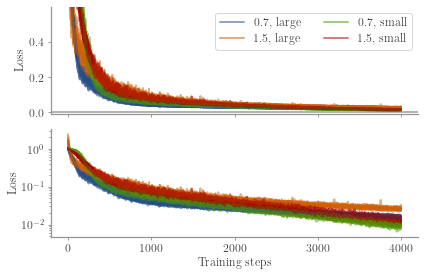

In [3]:
# Plot learning curves 
lbl_sce = ["%.1f, %s" % (gs[i_sce], out_scales[i_sce]) for i_sce in range(n_sce)]
n_rows = 2
n_cols = 1
fig = plt.figure(figsize=(6, 4))
axes = subplots(fig, n_rows, n_cols, sharex=True)
for i_r in range(n_rows):
    for mi in np.ndindex(*n_mi):
        i_s, i_sce = mi
        c = colors[i_sce]
        ax = axes[i_r, 0]
        loss = loss_all[mi]
        lbl = lbl_sce[i_sce] if i_s == 0 else None
        ax.plot(steps, loss, c=c, label=lbl, alpha=0.5)
    ax.set_ylabel("Loss")
ax = axes[0, 0]
ax.legend(ncol=2)
ax.axhline(0, c=c_leg, zorder=-1)
ax.set_ylim(-0.01, 0.6)
# ax.set_ylim(-0.01, 0.02)
ax = axes[1, 0]
ax.set_yscale("log")

ax.set_xlabel("Training steps")
fig.tight_layout()
style.fixticks(fig)

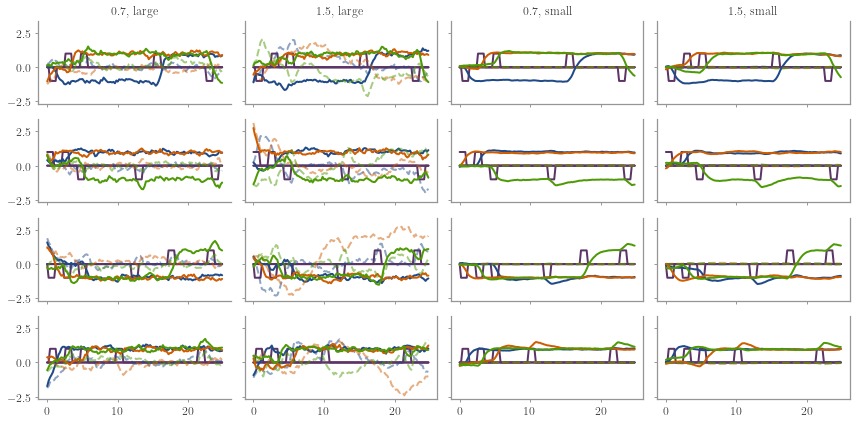

In [6]:
# Plot the task
n_show = min(batch_size, 4)

fig = plt.figure(figsize=(12, 1.5 * n_show))
n_cols = n_sce
n_rows = n_show
axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)

# for mi in np.ndindex(*n_mi):
#     i_s, i_sce = mi
ts_ev, input_ev, target_ev, mask_ev, _, _ = task_ev
for i_sce in range(n_sce):
    i_s = 0
    mi = i_s, i_sce
    for i_b in range(n_show):
        ax = axes[i_b, i_sce]
        # Input
        for i_in in range(dim_in):
            ax.plot(ts_ev, input_ev[i_b, :, i_in], c=colors[4])
        for i_out in range(dim_out):
            c = colors[i_out]
            # Target
            m = mask_ev[i_b, :, i_out]
            # ax.plot(ts_ev[m], target_ev[i_b, :, i_out][m], 'o', ms=3, c=c)
            # Output
            for i_if in range(2):
                output = output_all[i_if][mi]
                ls = ['--', '-'][i_if]
                alpha = [0.5, 1.][i_if]
                ax.plot(ts_ev, output[i_b, :, i_out], ls, c=c, alpha=alpha)
    ax = axes[0, i_sce]
    lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce])
    ax.set_title(lbl)
fig.tight_layout()
style.fixticks(fig)

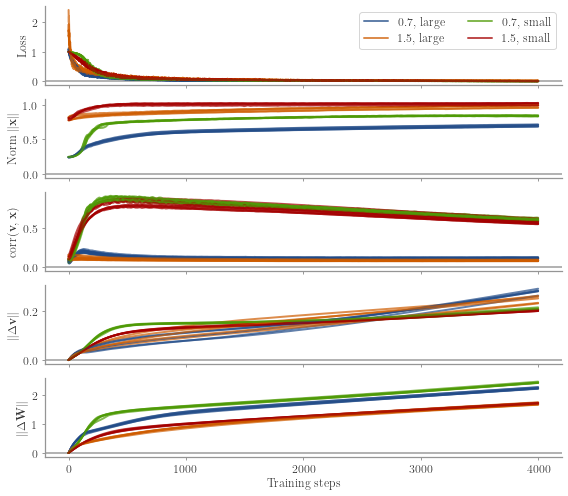

In [ ]:
# Plot the evolution of norm and overlaps
n_rows = 5
n_cols = 1
fig = plt.figure(figsize=(8, 7))
axes = subplots(fig, n_rows, n_cols, sharex=True)
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    c = colors[i_sce]
    lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce]) if i_s == 0 else None
    # Loss
    ax = axes[0, 0]
    loss = loss_all[mi]
    ax.plot(steps, loss, c=c, label=lbl, alpha=0.7)
    
    # Norm
    ax = axes[1, 0]
    ax.plot(steps, h_norm_all[mi] / np.sqrt(dim_hid), c=c, label=lbl, alpha=0.7)
    # ax.plot(steps, dh_norm_all[mi] / np.sqrt(dim_hid), '--', c=c, label=lbl, alpha=0.7)
    
    # Correlation between w_out and hidden
    ax = axes[2, 0]
    ax.plot(steps, corr_w_h_all[mi], c=c, label=lbl, alpha=0.7)
    # ax.plot(steps, corr_w_dh_all[mi], '--', c=c, label=lbl, alpha=0.7)
    
    # Weight changes
    ax = axes[3, 0]
    ax.plot(steps, dw_out_norm_all[mi], c=c, label=lbl, alpha=0.7)
    ax = axes[4, 0]
    ax.plot(steps, dw_rec_norm_all[mi], c=c, label=lbl, alpha=0.7)
    
    
ax = axes[0, 0]
ax.axhline(0, c=c_leg, zorder=-1)
ax.legend(ncol=2)
ax.set_ylabel("Loss")
# ax.set_ylim(-0.05, 1.1)
# ax.set_ylim(-0.01, 0.02)

ax = axes[1, 0]
ax.axhline(0, c=c_leg, zorder=-1)
ax.set_ylabel(r"Norm $\|\mathbf{x}\|$")
# ax.set_ylim(-0.05, 1.1)

ax = axes[2, 0]
ax.set_ylabel(r"corr($\mathbf{v},\,\mathbf{x}$)")
# ax.set_yscale('log')
ax.axhline(0, c=c_leg, zorder=-1)

ax = axes[3, 0]
ax.set_ylabel(r"$\|\Delta \mathbf{v}\|$")
ax.axhline(0, c=c_leg, zorder=-1)
ax = axes[4, 0]
ax.set_ylabel(r"$\|\Delta \mathbf{W}\|$")
ax.axhline(0, c=c_leg, zorder=-1)

ax.set_xlabel("Training steps")
fig.tight_layout()
style.fixticks(fig)

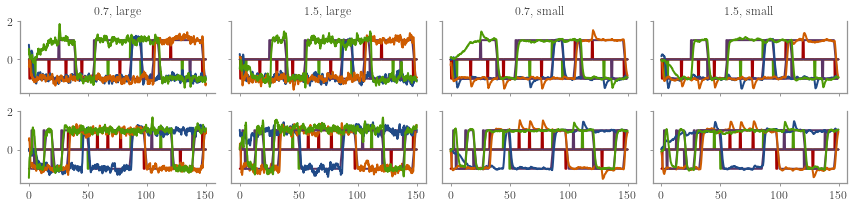

In [ ]:
# Plot the task
n_show = min(batch_size, 2)
fig = plt.figure(figsize=(12, 1.5 * n_show))
n_cols = n_sce
n_rows = n_show
axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)

ts_ex, input_ex, target_ex, mask_ex, noise_input_ex, noise_init_ex = task_ex
for i_sce in range(n_sce):
    i_s = 0
    mi = i_s, i_sce
    for i_b in range(n_show):
        ax = axes[i_b, i_sce]
        if task_name == "mante":
            # Input
            for i_in in range(dim_in):
                c = colors[i_in % task_params["n_tasks"]]
                ax.plot(ts_ex, input_ex[i_b, :, i_in] * 2, c=c)
            for i_out in range(dim_out):
                c = colors[i_out+2]
                # Target
                m = mask_ex[i_b, :, i_out]
                target_show = target_ex[i_b, :, i_out].copy()
                target_show[~m] = np.nan
                ax.plot(ts_ex, target_show, 'o', ms=3, alpha=1., c=colors[4])
                # Output
                output = output_ex[mi]
                ax.plot(ts_ex, output[i_b, :, i_out], c=c)
        elif task_name == 'romo':       
            # Input
            for i_in in range(dim_in):
                ax.plot(ts_ex, input_ex[i_b, :, i_in], c=colors[4])
            for i_out in range(dim_out):
                c = colors[i_out]
                # Target
                m = mask_ex[i_b, :, i_out]
                target_show = target_ex[i_b, :, i_out].copy()
                target_show[~m] = np.nan
                ax.plot(ts_ex, target_show, 'o', ms=3, alpha=1., c=colors[4])
                # Output
                # Output
                output = output_ex[mi]
                ax.plot(ts_ex, output[i_b, :, i_out], c=c)
        else:
            # Input
            for i_in in range(dim_in):
                ax.plot(ts_ex, input_ex[i_b, :, i_in] * 1, c=colors[i_in + 2])
            for i_out in range(dim_out):
                c = colors[i_out]
                # Target
                m = mask_ex[i_b, :, i_out]
                ax.plot(ts_ex[m], target_ex[i_b, :, i_out][m] + 0., '-', ms=2, c=colors[4])
                # Output
                output = output_ex[mi]
                ls = '-'
                alpha = 1.
                ax.plot(ts_ex, output[i_b, :, i_out], ls, c=c, alpha=alpha)
                
    ax = axes[0, i_sce]
    lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce])
    ax.set_title(lbl)
fig.tight_layout()
style.fixticks(fig)

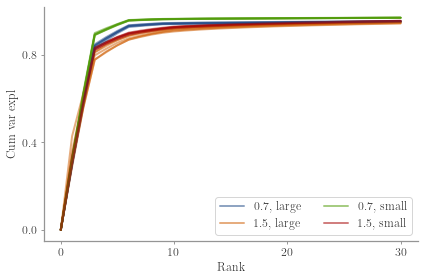

In [ ]:
# PCA of hidden dynamics
n_comp = 30
n_trunc = n_comp + 1
ranks_trunc = np.arange(n_trunc)

# Which hidden states to analyze?
plot_ev = False
if plot_ev:
    i_if = 1
    hids_pl = hids_all[i_if]
    task_pl = task_ev
else:
    hids_pl = hids_ex
    task_pl = task_ex

n_t_pl = hids_pl.shape[-2]

# Results arrays
h_proj_pl = np.zeros((*n_mi, batch_size, n_t_pl, n_comp))
cevr_pl = np.zeros((n_samples, n_sce, n_comp+1))

# Min and max time for pca
t_pc_min = 0
t_pc_max = n_t_pl
if task_name == "cycling":
    pass
    t_pc_min = 10
elif task_name == "flipflop":
    t_pc_min = 0
elif task_name == "mante":
    t_pc_max = 48
elif task_name == "romo":
    t_pc_min = 0
if task_name == "complex_sine":
    t_pc_min = 5
n_t_pc_min = int(t_pc_min / (dt * rec_step_dt))
n_t_pc_max = int(t_pc_max / (dt * rec_step_dt))

for mi in np.ndindex(*n_mi):
    h = hids_pl[mi][:, n_t_pc_min:n_t_pc_max].reshape(-1, dim_hid)
    pca = PCA(n_comp)
    pca.fit(h)
    ps = pca.components_
    h_proj_pl[mi] = hids_pl[mi] @ ps.T
    cevr_pl[mi][1:] = pca.explained_variance_ratio_.cumsum()

# Plot variance explained
lbl_sce = ["%.1f, %s" % (gs[i_sce], out_scales[i_sce]) for i_sce in range(n_sce)]
n_rows = 1
n_cols = 1
fig = plt.figure(figsize=(6, 4))
axes = subplots(fig, n_rows, n_cols, sharex=True)
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    c = colors[i_sce]
    ax = axes[0, 0]
    lbl = lbl_sce[i_sce] if i_s == 0 else None
    ax.plot(ranks_trunc, cevr_pl[mi], c=c, alpha=0.5, label=lbl)
ax.set_ylabel("Cum var expl")
ax.legend(ncol=2)
ax.set_xlabel("Rank")
fig.tight_layout()
style.fixticks(fig)

/tmp/ipykernel_31047/2027026133.py:236: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


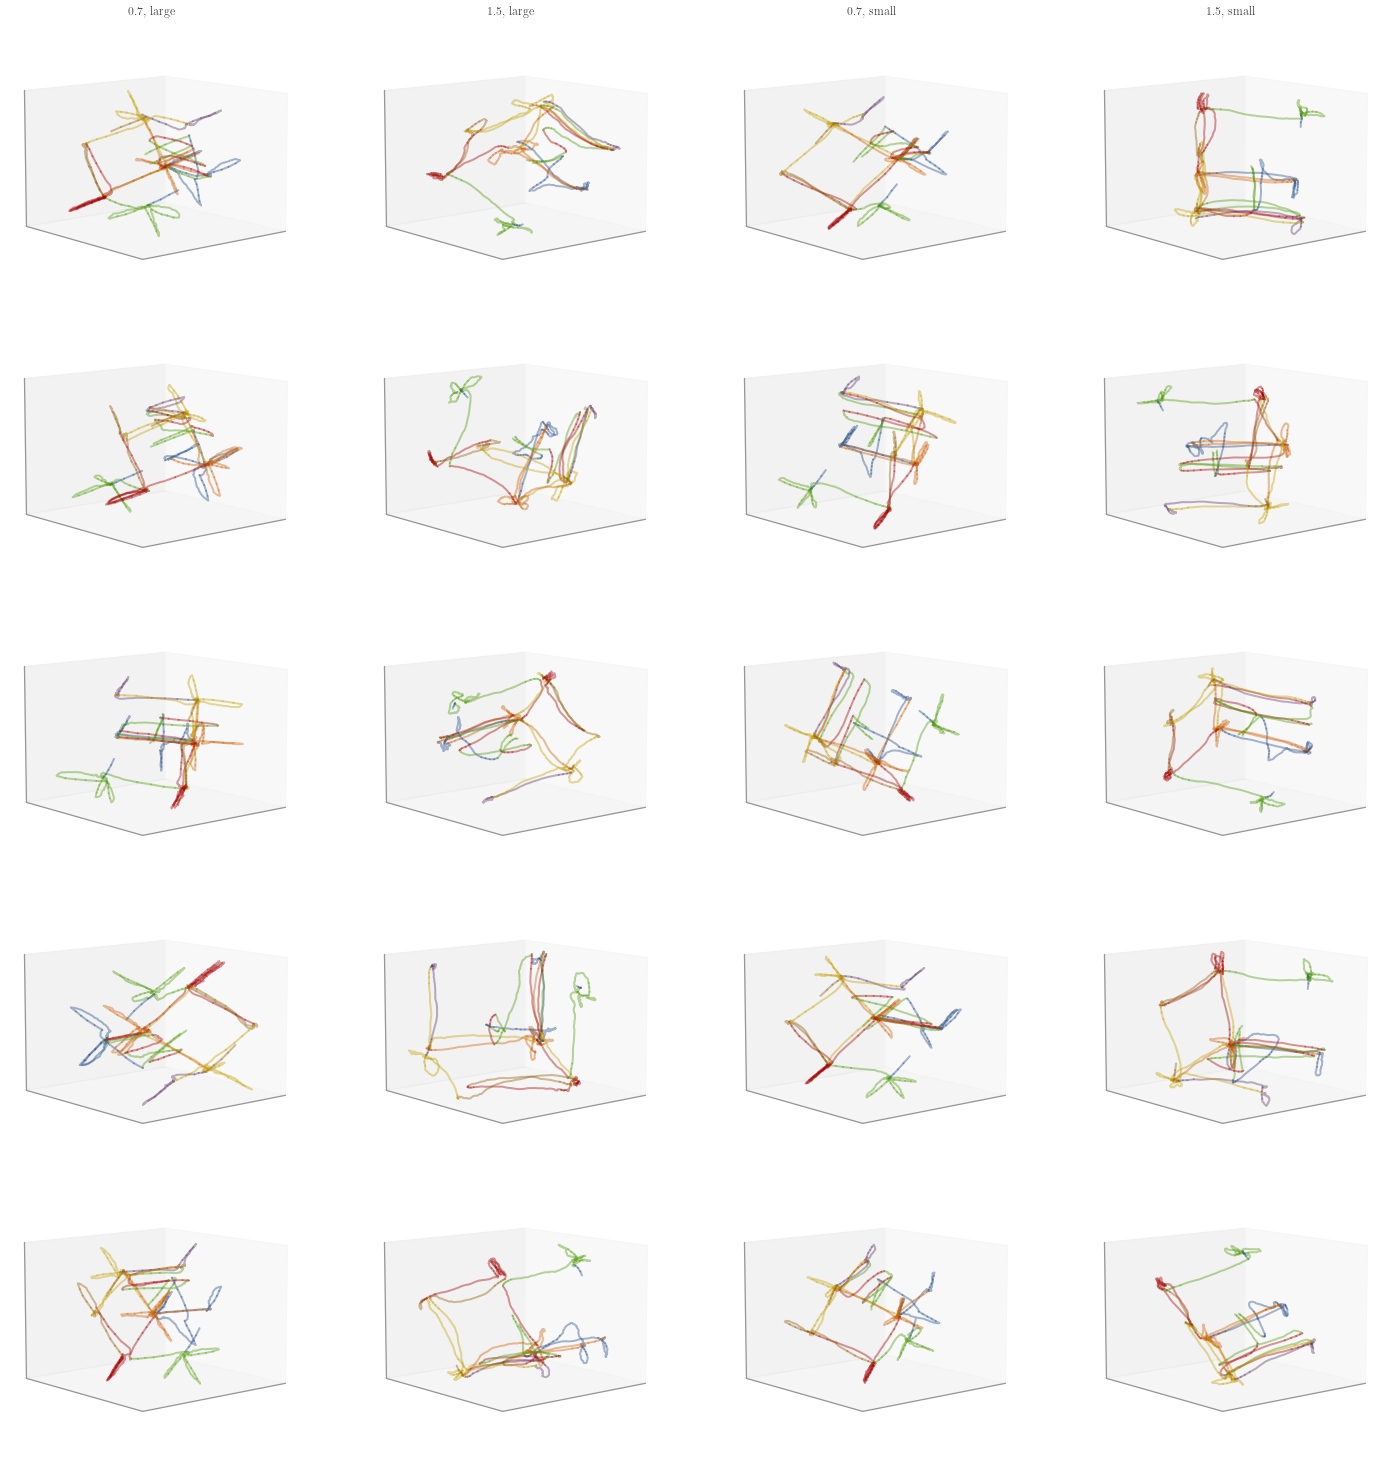

In [ ]:
## Plot PCA
samples_plt = np.arange(n_samples)
n_rows = len(samples_plt)
n_show = min(batch_size, 2)
n_cols =  n_sce

fig_width = 20
fig_height = 4 * n_rows
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')
plot_3d = True
dim_p = 2 + plot_3d
# PCA
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.)
axes = np.array([[fig.add_subplot(gs0[k, j], projection='3d' if plot_3d else None)
                      for j in range(n_cols)] for k in range(n_rows)])

ts_pl, input_pl, target_pl, mask_pl, _, _ = task_pl
for i_r, i_b, i_c in np.ndindex(n_rows, n_show, n_cols):
    ax = axes[i_r, i_c]
    i_s = samples_plt[i_r]
    i_sce = i_c
    mi = i_s, i_sce
    alphas = 0.7
    cs_if = cs[i_sce][[1, 0]]
    
    # PCA
    i_if = 1
    h_proj = h_proj_pl[i_s, i_sce, i_b]
    input = input_pl[i_b]
    target = target_pl[i_b]
    mask = mask_pl[i_b]
    
    if task_name == "flipflop":
        # 3-bit flipflop: there should be 8 combinations
        # Separate trail by input pulses
        has_pulse = np.any(np.abs(input) > 0, axis=-1)
        i_t0s = []
        ctas = []
        i_t1 = 0
        n_fp = task_params["n_tasks"]
        cta = np.zeros(n_fp)
        while True:
            if not np.any(has_pulse[i_t1:]):
                break
            i_t0 = np.argmax(has_pulse[i_t1:]) + i_t1
            pulse_len = 1
            i_t1 = i_t0 + pulse_len
            # What is the current target? Integrate the last pulses.
            ta = input[i_t0]
            cta = np.minimum(np.maximum(cta + 2 * ta, -1), 1)
            # Save
            i_t0s.append(i_t0)
            ctas.append(cta)
        i_t0s = np.array(i_t0s)
        ctas = np.array(ctas)
        for i_p, i_t0 in enumerate(i_t0s):
            if i_t0 > n_t_pc_min:
                cta = ctas[i_p]
                ta = (ctas[i_p] + 1)/2
                dec_num = int((ta[::-1] * 2**np.arange(len(ta))).sum())
                c = colors[dec_num]
                if i_p == len(i_t0s)-1:
                    i_tn = n_t_ev
                else:
                    i_tn = i_t0s[i_p+1]
                i_t1 = i_t0 + pulse_len
                # ax.plot(*h_proj[i_t0:i_t1, :dim_p].T, '--', c=c, alpha=0.2)
                # ax.plot(*h_proj[i_t1:i_tn, :dim_p].T, '-', c=c, alpha=0.4)
                ax.plot(*h_proj[i_t0:i_tn+1, :dim_p].T, '-', c=c, alpha=0.4)
    elif task_name == "mante":
        # Color according to context and stimulus difference
        # Decode context
        n_tasks = task_params["n_tasks"]
        ctx_begin = np.argmax(input[:, :n_tasks].sum(axis=1) > 0)
        ctx_end = np.argmax(input[ctx_begin:, :n_tasks].sum(axis=1) == 0) + ctx_begin
        ctx = np.where(input[ctx_begin, :n_tasks] > 0)[0][0]
        # Retrieve sign and input strength
        stim_begin = ctx_begin
        stim_end = ctx_end
        mean_input = input[stim_begin:stim_end, n_tasks+ctx].mean()
        # Target
        target_begin = np.argmax(target[:, 0] != 0.)
        target_end = np.argmax(target[target_begin:, 0] == 0.) + target_begin
        target_val = target[target_begin, 0]
        
        # Color only by sign of target and context
        idx_c = int(ctx * 2 + (target_val + 1) / 2)
        c = colors[idx_c]
        if i_b == 0 and i_r == 0 and i_c == 0:
            for i_ctx, i_tar in np.ndindex(n_tasks, 2):
                idx_c_leg = i_ctx * 2 + i_tar
                ax.plot(*h_proj[0, :dim_p].T, '-', c=colors[idx_c_leg], alpha=alpha, 
                        label="Ctx %d, target %d"%(i_ctx, 2*i_tar-1))
        
        # ### PCA
        # ax.plot(*h_proj[n_t_pc_min:n_t_pc_max, :dim_p].T, '-', c=c, alpha=alpha)
        ### Phases
        alpha = 0.5
        # ax.plot(*h_proj[:stim_begin, :dim_p].T, '--', c=c, alpha=alpha)
        ax.plot(*h_proj[stim_begin:stim_end, :dim_p].T, ':', c=c, alpha=alpha)
        # ax.plot(*h_proj[stim_end:target_begin+1, :dim_p].T, '-', c=c, alpha=alpha)
        # ax.plot(*h_proj[target_begin:target_end, :dim_p].T, '-', ms=4, c=c, alpha=alpha)
        ax.plot(*h_proj[stim_end:target_end, :dim_p].T, '-', ms=4, c=c, alpha=alpha)
        # ax.plot(*h_proj[target_begin, :dim_p].T, '*', ms=4, c=c, alpha=alpha)
        ax.plot(*h_proj[target_end-1, :dim_p].T, '*', ms=6, c=c)
        ax.plot(*h_proj[target_end:, :dim_p].T, '--', ms=4, c=c, alpha=alpha)
    elif task_name == "romo":
        # Color according to stimulus difference
        # Times and stimulus diff
        stim0_begin = np.argmax(np.abs(input.sum(axis=-1)) > 0)
        stim0_end = stim0_begin + np.argmax(input[stim0_begin:].sum(axis=-1) == 0)
        stim1_begin = stim0_end + np.argmax(np.abs(input[stim0_end:].sum(axis=-1)) > 0)
        stim1_end = stim1_begin + np.argmax(input[stim1_begin:].sum(axis=-1) == 0)
        stim0 = input[stim0_begin].sum()
        stim1 = input[stim1_begin].sum()
        stim_diff = stim1 - stim0
        # Color 
        input_amp = 1
        rel_input_amp_min = 0.5
        rel_input_amp_max = 1.5
        stim_diff_max = input_amp * (rel_input_amp_max - rel_input_amp_min)
        cmap = "PiYG"
        c_iter_pulse = color_iterator(stim_diff_max+1, cmap, vmin=-stim_diff_max)
        c = c_iter_pulse(stim_diff)
        # ax.plot(*h_proj[:n_t_pc_min, :dim_p].T, '--', c=c, alpha=alpha)
        # ax.plot(*h_proj[n_t_pc_min:, :dim_p].T, '-', c=c, alpha=alpha)
        # At pulses
        c2 = colors[3] if stim_diff < 0 else colors[2]
        ax.plot(*h_proj[stim0_end-1, :dim_p].T, 'o', ms=6, c=c2, alpha=alpha)
        ax.plot(*h_proj[stim1_end-1, :dim_p].T, 's', ms=6, c=c2, alpha=alpha)
        # ax.plot(*h_proj[stim0_end:stim1_begin, :dim_p].T, 'o-', ms=3, c=c2, alpha=0.3)
        n_t_delay_max = int(8/dt)
        ax.plot(*h_proj[stim0_end:stim0_end+n_t_delay_max, :dim_p].T, 'o-', ms=3, c=c2, alpha=0.1)
        ax.plot(*h_proj[stim0_end+n_t_delay_max:stim1_begin, :dim_p].T, 'o-', ms=3, c=c2, alpha=0.3)
        # ax.plot(*h_proj[stim1_begin-10:stim1_begin, :dim_p].T, 'o-', ms=3, c=c2, alpha=0.3)
    elif task_name == "complex_sine":
        # Color target by input, i.e. the desired frequency
        tt = np.argmax(np.abs(input.sum(axis=-1)) > 0)
        in_val = input[tt, 0]
        c_iter = color_iterator(2, "viridis")
        c = c_iter(in_val)
        ax.plot(*h_proj[:n_t_pc_min, :dim_p].T, '--', c=c, alpha=alpha)
        ax.plot(*h_proj[n_t_pc_min:, :dim_p].T, '-', c=c, alpha=alpha)
    else:
        c = colors[i_b]
        ax.plot(*h_proj[:n_t_pc_min, :dim_p].T, '--', c=c, alpha=alpha)
        ax.plot(*h_proj[n_t_pc_min:n_t_pc_max, :dim_p].T, '-', c=c, alpha=alpha)

    if i_b == 0:
        if plot_3d:
            # Perspective
            ax.azim = 50
            ax.dist = 10
            ax.elev = 10
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

        ax = axes[0, i_sce]
        lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce])
        ax.set_title(lbl)
        
        # if i_r == 0 and i_c == 0:
        #     ax.legend(ncol=2)
        
style.fixticks(fig)